In [23]:
import pandas as pd
import pymongo
import matplotlib.pyplot as plt

## MongoDB to DataFrame

In [26]:
# Mongodb 불러오기
import pymongo

# mongodb 연결
conn = pymongo.MongoClient()

# DB접근
db = conn['crawling_review']

# collection 접근
collection = db['movies']

In [43]:
# DataFrame
doc = collection.find_one()
data = pd.DataFrame(doc, columns=['star','comment'])
data.sample(10)

,star,comment
9437,10,ㅈㄴ재밋노명작이다 무조건봐야하노
4731,1,갑자기 도게자 ㄹㅇㅋㅋ
659,10,야만의 시대를 잘 고증했다. 재미 있는 것은 진실을 밝히자는 영화가 아니다. 당시의...
1270,10,
7449,9,고스트 버스터즈 속 장면들을 오마주한 장면들도 가득해 찾아보는 재미도 쏠쏠~
5271,10,7000년을 낭비하는 이터널즈와14000년을 기막히게 사용하는 맨 프럼 어스
3760,8,왜 재미없다고 한건지;; 괜찮게 본영화유체이탈이 되는 이유가 억지스럽긴함
1832,10,80년도에나 나왓어야 할 영화감독이 신세계 범죄도시 팬인듯 ㅋ
9597,1,돈 아까워욥.. 재미업ㄱ음
7006,10,재밌었어요 기대이상이였어요! 초반에는 살짝 지루하지만 중반부터 액션 보는 재미가 있...


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   star     9990 non-null   object
 1   comment  9990 non-null   object
dtypes: object(2)
memory usage: 156.2+ KB


In [56]:
# data tpye 변경
data = data.astype({'star':'int'})
data.dtypes

star        int32
comment    object
dtype: object

## label 설정

In [57]:
# 평점 7 이상 = 긍정(1)
data_pos = data[data['star']>=7]
data_pos['label'] = 1
data_pos

C:\Users\User\AppData\Local\Temp/ipykernel_19796/2313997164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['label'] = 1


,star,comment,label
0,10,평점이 낮아서 안보려다 봤는데 보길 정말 잘했슴ㄷㅏ.저는 지루하지않았고 후반부로 갈...,1
1,10,가슴 시리도록 기억에 오래 남을 영화. 공유 전도연의 연기는.. 잊혀지지 않을 것 ...,1
3,9,우리가 자라고 우리가 사랑을 하고 우리가 결혼을 하고 우리가 아이를 키우고 우리가 ...,1
5,7,믿고보는 황정밋 배우!!,1
8,10,으악 ㅋㅋ 너무무서웠어요 ㅠㅠ,1
...,...,...,...
9981,10,굿굿 ㅅ평점왜이러지?,1
9983,10,참신한 주제와 훌륭한 배우들과 연출 좋았습니다 몰입해서 잘 봤어요,1
9986,7,로맨스 영화를 가장한 SF물이라서 뭔가 아쉬움이 남는 영화.개봉당시 포스터만 봐도 ...,1
9987,10,"연출, 연기 다 좋습니다",1


In [59]:
# 평점 6 이하 = 부정(0)
data_neg = data[data['star']<7]
data_neg['label'] = 0
data_neg

C:\Users\User\AppData\Local\Temp/ipykernel_19796/1242165523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['label'] = 0


,star,comment,label
2,1,대체... 이게 뭐죠?,0
4,1,보는 내가 유체이탈할뻔 보다가 나온 영화는 처음임답답하고 주인공 본인도 몰라 답답한...,0
6,1,고양이가 그렇게 불쌍하시면 데려가서 키우세요. 집없이 밖에서 벌벌떠는 고양이들이 불...,0
7,2,연출 연기 스토리 전부 잘못된 영화,0
9,1,중국 자본인 게 너무 티나서 아쉽다.,0
...,...,...,...
9980,5,재미없음,0
9982,3,"필름을 드라마 찍을때 사용하는 방식으로 찍엇노??? 장혁,유오성 너무 아깝다. 감독...",0
9984,4,강원도사투리가 넘쎄서 영화스타일이랑 안어울림. 뭐라고하는지 원...,0
9985,6,님의 하드캐리,0


In [64]:
# 데이터 합치고 필요없는 column 제거
df = pd.concat([data_pos,data_neg], ignore_index=True)
df.sample(10)

,star,comment,label
7551,5,흠… 최근본 디즈니영화중에는 제일 별로였다 뭔가 딱히 재미가없었음…하지만 화려한 색...,0
7049,1,이채영배우 팬인데 애초에 이딴 4류 웹툰을 왜 영화화 하기로 했는지도 의문이고 영화...,0
6057,10,120시간 일해야 한다는 사람이 꼭 봐야할 영화. 한 사람의 희생으로 결국은 나 또...,1
2193,10,어린이 영화 맞냐?,1
3350,10,말이 되고 안되고는 문제되지 않는다. 너무 아름다운 영화다.,1
6986,1,"납치범이 사람 때릴 줄만 알고, 머리는 원체 쓰질 않음",0
5359,8,"보는 내내 ""대체 무슨 내용이지?"" 하다가 막판에 치솟는 전율 ㄷㄷ 다시 보면 감상...",1
314,8,이 배우들이 다 나온다고? 캐스팅에 놀람,1
6627,10,의무감으로라도 봐야한다,1
8887,2,알바들 많이 썻구먼.. 정말 재미없네 보지마삼 ㅜㅜ,0


1    6924
0    3066
Name: label, dtype: int64


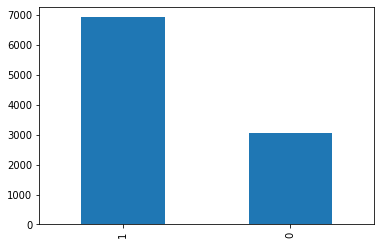

In [67]:
# label 비율 확인, 불균형은 SMOTE로 해겷기
df['label'].value_counts().plot.bar()
print(df['label'].value_counts())

## Preprocessing

In [75]:
# NA 확인
df.isna().sum()

star       0
comment    0
label      0
dtype: int64

In [77]:
# comment가 없는 경우 제외
df = df[df['comment']!='']
df.sample(10)

,star,comment,label
8621,1,드럽게 재미없음 엄청나게,0
9129,1,좌빨 만화군구나 ㅡㅡ거른다,0
5982,7,"안야 테일러 조이, 그녀와 '지난밤극장에서' 함께한 지금 이 '순간', 황홀하고 아...",1
4343,10,감동적이면서 유머가 있고 편견에대한 우리들의 진짜가 무엇인지 말해주는 이야기.,1
5212,7,볼만한 액션 영화 이거보던 시절이 그립네,1
9780,1,아무리 생각없이 본다고하지만.. 여성들이 무슨 노리개냐!! 이걸 영화라고 만들다니....,0
7695,1,그냥 더러운 영화..감독들의 온갖 촌스러운 망상의 향연,0
5598,10,여운이 정말 많이 남는 영화.. 최고,1
1510,10,아. 2시간이 순삭되는 몰입의 순간.,1
801,7,이런류의 영화 많이 좋아하는데아쉬운점도 크고 그래도 볼만은 했다,1
